In [416]:
import pandas as pd
import numpy as np
from sklearn import svm
import sklearn.preprocessing as skp
# import np_utils
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle

# Basic Code
This part can be ignored, it serves to build the technical process to develop the actual model, but doesn't contain too much to interpret from a model evaluation point of view

In [417]:
#Creates Lagged series
#Goes through a series and generates an lag+1 dimensional pandas DataFrame that has each previous lag timeunit
#as a column and current as the last cobilumn
#Input: Pandas Series
#Output: lag+1 dimensional DataFrame

def timeseriesLagged(data, lag=60):
    df = data
    columns = [df.shift(i) for i in range(1, lag+2)] 
    df = pd.concat(columns,axis=1)
    df.fillna(0, inplace=True)
    df.columns = [str(lag+2-x) for x in range(1,lag+2)]
    # df.reset_index(inplace=True,drop=False)
    df = df[df.columns[::-1]] #Flip because we want newer data on the right
    df= df.iloc[lag+1:] # drop the first 'lag' columns because zeroes.
    df.reset_index(drop=True,inplace=True)
    return df

# Binarizes the last column into 1, 0, -1. 1 = buy 0 = do nothing -1 = sell
# Rate is the percent increase or decrease that should trigger a buy or a sell
# lag is the time unit of lag. 
# atleast is how many of the lookahead need to be atleast the same or greater than flat+rat
# Input: lagged pandas DataFrame, uint lag, double dif, double flat, double atleast between 0 and 1
# Output : Pandas Dataframe with last column binarized
def binarizeTime(resLagged,rate = 0,lookahead = 0, flat = 0,atleast = 0.5):
    if lookahead <= 0 :
        raise Exception("lookahead Must be 1 or higher!")
    resLagged = resLagged.copy() # Make a deep copy
    last = np.shape(resLagged)[1] # find the length of the data 
    last = last-lookahead # convert it to string for loc
    colsLookAhead = list(resLagged.loc[:,str(last+1):str(last + lookahead)])
    colsLast = resLagged[str(last)]
    diffs = resLagged[colsLookAhead].subtract(colsLast,axis=0)
#     print(diffs)
    greater = diffs>=flat  # all the times the price changed higer than flat
    greater = np.count_nonzero(greater,axis=1).reshape((1,-1))
    lesser = diffs<=-flat # all the times the price fell lower than fat
    lesser = np.count_nonzero(lesser,axis=1).reshape((1,-1))
#     return greater,lesser
#     print(greater)
    greater = greater.reshape(1,-1)
    changeToBuy = np.any(greater > lesser & np.greater(greater,atleast*lookahead),axis=0) # make sure more rises than falls and atleast half rises
    changeToSell = np.any(lesser > greater & np.greater(lesser,atleast*lookahead),axis=0)      # make sure more falls than rises and atleast half rises
    changeToHold = ~changeToBuy & ~changeToSell
    resLagged = resLagged.drop(colsLookAhead,1)
    resLagged.loc[changeToSell,str(last+1)] = -1 # Set sell to -1
    resLagged.loc[changeToBuy,str(last+1)] = 1 # Set buy to 1
    resLagged.loc[changeToHold,str(last+1)] = 0 # Set to 0
    return resLagged

In [381]:
# Nifty. Reading and Cleaning
h = 5
fut = pd.read_csv("Nifty50FUT.csv")
fut['Price']= fut['Price'].str.replace(",","").astype(np.double).rolling(h).mean()
fut['Open']= fut['Open'].str.replace(",","").astype(np.double).rolling(h).mean()
fut['High']= fut['High'].str.replace(",","").astype(np.double).rolling(h).mean()
fut['Low']= fut['Low'].str.replace(",","").astype(np.double).rolling(h).mean()
fut['Vol.']= fut['Vol.'].str.replace(",","").str.replace("M","e6").str.replace("-","0").str.replace("K","e3").astype(np.double).rolling(h).mean()
fut = fut[::-1]
fut.reset_index(inplace=True, drop = True)

nifty = pd.read_csv("Nifty.csv")
nifty = nifty[::-1]
nifty.reset_index(inplace=True, drop = True)
nifty['Price']= nifty['Price'].str.replace(",","").astype(np.double).rolling(h).mean()
nifty['Open']= nifty['Open'].str.replace(",","").astype(np.double).rolling(h).mean()
nifty['High']= nifty['High'].str.replace(",","").astype(np.double).rolling(h).mean()
nifty['Low']= nifty['Low'].str.replace(",","").astype(np.double).rolling(h).mean()
nifty['Vol.']= nifty['Vol.'].str.replace(",","").str.replace("M","e6").str.replace("-","0").str.replace("K","e3").astype(np.double).rolling(h).mean()


niftyDrop = np.setdiff1d(fut['Date'].values,nifty['Date'].values)
futDrop = np.setdiff1d(nifty['Date'].values,fut['Date'].values)
nifty = nifty[~nifty.Date.isin(futDrop)]
fut = fut[~fut.Date.isin(niftyDrop)]

In [ ]:
fut['Price']

In [ ]:
# Nifty Base
volNifty = nifty['Vol.'].diff().dropna()
openNifty = nifty['Open'].diff().dropna()
highNifty = nifty['High'].diff().dropna()
lowNifty = nifty['Low'].diff().dropna()
dataNifty = nifty['Price'].diff().dropna()

# Nifty Futs
volFut = fut['Vol.'].diff().dropna()
openFut = fut['Open'].diff().dropna()
highFut = fut['High'].diff().dropna()
lowFut = fut['Low'].diff().dropna()
dataFut = fut['Price'].diff().dropna()
#Future Premium
prems = dataFut.values - dataNifty.values
prems = pd.Series(prems)

In [ ]:
lag=15
lookahead = 1
flat = 0
# First N predicts N+1th. Creating the 1st N series
closeNifty = timeseriesLagged(dataNifty,lag + lookahead-1)
# These are correlated with closeNifty, so we will ignore them for now
# openNifty = timeseriesLagged(openNifty,lag + lookahead-1).drop(str(lag+1),axis=1)
# highNifty = timeseriesLagged(highNifty,lag + lookahead-1).drop(str(lag+1),axis=1)
# lowNifty = timeseriesLagged(lowNifty,lag + lookahead-1).drop(str(lag+1),axis=1)

volNifty = timeseriesLagged(volNifty,lag + lookahead-1).drop(str(lag+1),axis=1)
volNifty = skp.minmax_scale(volNifty,axis=1)

# First N predicts N+1th. Creating the 1st N series
closeFut = timeseriesLagged(dataFut,lag + lookahead-1).drop(str(lag+1),axis=1)
closeFut = skp.minmax_scale(closeFut,axis=1)

# These are correlated with closeNifty, so we will ignore them for now
# openNifty = timeseriesLagged(openNifty,lag + lookahead-1).drop(str(lag+1),axis=1)
# highNifty = timeseriesLagged(highNifty,lag + lookahead-1).drop(str(lag+1),axis=1)
# lowNifty = timeseriesLagged(lowNifty,lag + lookahead-1).drop(str(lag+1),axis=1)
volFut = timeseriesLagged(volFut,lag + lookahead-1).drop(str(lag+1),axis=1)
volFut = skp.minmax_scale(volFut,axis=1)

prems = timeseriesLagged(prems,lag + lookahead-1).drop(str(lag+1),axis=1)
prems = skp.minmax_scale(prems,axis=1)





In [ ]:
closeNifty.loc[closeNifty[str(lag+1)] > flat,str(lag+1)] = 1
closeNifty.loc[closeNifty[str(lag+1)] <= flat,str(lag+1)] = 2
closeNifty.loc[closeNifty[str(lag+1)] == flat,str(lag+1)] = 3


In [ ]:
n = 5
buySeriesLabs = closeNifty[str(lag+1)] # labels
buySeriesFeats = closeNifty.drop(str(lag+1),axis=1) #features
buySeriesFeats = buySeriesFeats.values
buySeriesFeats = skp.scale(buySeriesFeats,axis=1)

buySeries = np.zeros((len(buySeriesFeats),buySeriesFeats.shape[-1],n))
buySeries[:,:,0] = buySeriesFeats
buySeries[:,:,1] = volFut
buySeries[:,:,2] = prems
buySeries[:,:,3] = closeFut
buySeries[:,:,4] = volNifty



In [ ]:
x,y = buySeries,buySeriesLabs
x,y = shuffle(x,y)
tot = len(x)
y = y.values
yOrig = np.copy(y)

x = x.reshape(len(x),-1)
trainPercent = 0.9 # majority of data used for training
testPercent = 0.9 # 
valPercent = 1.00  #

# Test Train Val Split

xTrain = x[0:int(trainPercent*tot),:]
yTrain = y[0:int(trainPercent*tot)]

xTest = x[int(trainPercent*tot): int(testPercent*tot),:]
yTest = y[int(trainPercent*tot): int(testPercent*tot)]

xVal = x[int(testPercent*tot):,:]
yVal = y[int(testPercent*tot):]

In [ ]:
clf = svm.SVC(kernel='rbf')
clf.fit(xTrain, yTrain) 

In [ ]:
preds = clf.predict(xVal)
print(sum(preds==yVal)/len(yVal))
print(confusion_matrix(yVal,preds))

# Actual Dataset
We will try to use Open Interest, Volume, Price from Nifty Futures and Price and Volume from Nifty from the last $LAG$ (variable, will adjust as fit) to make a prediction on whether nifty will increase or decrease as compared to $h$ days ago.

In [689]:
# Read all the data from the csv files
nifty = pd.read_csv("NiftyPrice.csv")
nifty = nifty[::-1] # Reverse to align
nifty.reset_index(inplace=True, drop = True)
nifty.rename(columns={ nifty.columns[0]: "Date" },inplace=True)

futOI = pd.read_csv("NiftyFutOI.csv")
futOI = futOI[::-1] # Reverse to align
futOI.reset_index(inplace=True, drop = True)
futOI.rename(columns={ futOI.columns[0]: "Date" },inplace=True)

fut = pd.read_csv("NiftyFutPrice.csv")
fut = fut[::-1] # reverse to align
fut.reset_index(inplace=True, drop = True)
fut.rename(columns={ fut.columns[0]: "Date" },inplace=True)

oil = pd.read_csv("oil.csv")
# oil = oil[::-1]
oil.reset_index(inplace=True, drop = True)
oil.rename(columns={ oil.columns[0]: "Date" },inplace=True)

usdinr = pd.read_csv("usdinr.csv")
usdinr.rename(columns={ usdinr.columns[0]: "Date" },inplace=True)

advances = pd.read_csv("advances.csv")
advances.rename(columns={ advances.columns[0]: "Date" },inplace=True)

declines = pd.read_csv("decline.csv")
declines.rename(columns={ declines.columns[0]: "Date" },inplace=True)
# Drop any rows not common in both
# Data Arrays
dat = [nifty,fut,futOI,oil,usdinr,advances,declines]

# Clean and make sure they have the same dates
dropset = [] # Collect the dropsets
n = 2
for cleanee in dat: # O(n^2)
    for cleaner in dat: 
        drop = np.setdiff1d(cleaner['Date'].values,cleanee['Date'].values) # Everything in cleaner AND not in cleanee
        dropset.append(drop)

for i in range(0,len(dat)): # Actuall drop
    for drop in dropset:
        dat[i] = dat[i][~dat[i].Date.isin(drop)]        


In [690]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [691]:
# Create % change daily bars of the different features
# Nifty Base
h = 1 # change from how far ago
t = 20
t2 = 9
t4 = 15
prices = dat[0]['PX_LAST'].diff().dropna()[t-1:]
volNifty = dat[0]['PX_VOLUME'].pct_change(h).dropna().rolling(t).mean().dropna()
volNiftyt2 = dat[0]['PX_VOLUME'].pct_change(h).dropna().rolling(t2).mean().dropna()
volNiftyt4 = dat[0]['PX_VOLUME'].pct_change(h).dropna().rolling(t4).mean().dropna()
lowestVolNiftyIndex = min(volNiftyt4.index)

dataNifty = dat[0]['PX_LAST'].pct_change(h).dropna().rolling(t).mean().dropna()
dataNiftyt2 = dat[0]['PX_LAST'].pct_change(h).dropna().rolling(t2).mean().dropna()
dataNiftyt4 = dat[0]['PX_LAST'].pct_change(h).dropna().rolling(t4).mean().dropna()

# Nifty Futs
volFut = dat[1]['PX_VOLUME'].pct_change(h).dropna().rolling(t).mean().dropna()
volFutt2 = dat[1]['PX_VOLUME'].pct_change(h).dropna().rolling(t2).mean().dropna()
volFutt4 = dat[1]['PX_VOLUME'].pct_change(h).dropna().rolling(t4).mean().dropna()

oiFut = dat[2]['OPEN_INT'].pct_change(h).dropna().rolling(t).mean().dropna()
oiFutt2 = dat[2]['OPEN_INT'].pct_change(h).dropna().rolling(t2).mean().dropna()
oiFutt4 = dat[2]['OPEN_INT'].pct_change(h).dropna().rolling(t4).mean().dropna()

dataFut = dat[1]['PX_LAST'].pct_change(h).dropna().rolling(t).mean().dropna()
dataFutt2 = dat[1]['PX_LAST'].pct_change(h).dropna().rolling(t2).mean().dropna()
dataFutt4 = dat[1]['PX_LAST'].pct_change(h).dropna().rolling(t4).mean().dropna()

# Oil
volOil = dat[3]['PX_VOLUME'].pct_change(h).dropna().rolling(t).mean().dropna()
volOilt2 = dat[3]['PX_VOLUME'].pct_change(h).dropna().rolling(t2).mean().dropna()
volOilt4 = dat[3]['PX_VOLUME'].pct_change(h).dropna().rolling(t4).mean().dropna()

dataOil = dat[3]['PX_LAST'].pct_change(h).dropna().rolling(t).mean().dropna()
dataOilt2 = dat[3]['PX_LAST'].pct_change(h).dropna().rolling(t4).mean().dropna()
dataOilt4 = dat[3]['PX_LAST'].pct_change(h).dropna().rolling(t4).mean().dropna()


# USDINR
dataUSDINR = dat[4]['Last Price'].astype(np.float).pct_change(h).dropna().rolling(t).mean().dropna()
dataUSDINRt2 = dat[4]['Last Price'].astype(np.float).pct_change(h).dropna().rolling(t2).mean().dropna()
dataUSDINRt4 = dat[4]['Last Price'].astype(np.float).pct_change(h).dropna().rolling(t4).mean().dropna()

# Advance Decline
advanceTot = dat[5]['PX_LAST'].rolling(h).mean()
declineTot = dat[6]['PX_LAST'].rolling(h).mean()
# advanceDecline = advanceDecline # drop the first row because we are dropping it in the others
advanceDecline = advanceTot/declineTot
advanceDecline = pd.Series(advanceDecline[t:])
# advanceDecline = advanceDecline.pct_change(h).dropna()*100

In [692]:
dataNifty.shape

(2088,)

In [693]:
lag = 3
lookahead = 1
flat = 0
# First N predicts N+1th. Creating the 1st N series
closeNifty = timeseriesLagged(dataNifty,lag + lookahead-1)

volNifty = timeseriesLagged(volNifty,lag + lookahead-1).drop(str(lag+1),axis=1)
# volNifty = skp.scale(volNifty,axis=1)

# First N predicts N+1th. Creating the 1st N series
closeFut = timeseriesLagged(dataFut,lag + lookahead-1).drop(str(lag+1),axis=1)
# closeFut = skp.scale(closeFut,axis=1)

volFut = timeseriesLagged(volFut,lag + lookahead-1).drop(str(lag+1),axis=1)
# volFut = skp.scale(volFut,axis=1)

oiFut = timeseriesLagged(oiFut,lag + lookahead-1).drop(str(lag+1),axis=1)
# oiFut = skp.scale(oiFut,axis=1)

# Oil
volOil = timeseriesLagged(volOil,lag + lookahead-1).drop(str(lag+1),axis=1)
# volOil = skp.scale(volOil,axis=1)
dataOil = timeseriesLagged(dataOil,lag + lookahead-1).drop(str(lag+1),axis=1)
# dataOil = skp.scale(dataOil,axis=1)

# USDINR
dataUSDINR = timeseriesLagged(dataUSDINR,lag + lookahead-1).drop(str(lag+1),axis=1)
# dataUSDINR = skp.scale(dataUSDINR,axis=1)


# Advance Decline
advanceDecline = timeseriesLagged(advanceDecline,lag + lookahead-1).drop(str(lag+1),axis=1)
# advanceDecline = skp.scale(advanceDecline,axis=1)

pricesDF = timeseriesLagged(prices,lag + lookahead-1)

In [694]:
actuals = closeNifty.copy()

In [695]:
# Binazrize the last column
Actuals = closeNifty.copy
toOne = pricesDF[str(lag+1)] > pricesDF[str(lag)]
toTwo = pricesDF[str(lag+1)] <= pricesDF[str(lag)]
closeNifty.loc[toOne,str(lag+1)] = 1
closeNifty.loc[toTwo,str(lag+1)] = 2
# closeNifty.loc[closeNifty[str(lag+1)] == closeNifty[str(lag)],str(lag+1)] = 3
closeNifty[str(lag+1)]=closeNifty[str(lag+1)].astype(np.int)

# Actuals
upday = pricesDF[str(lag+1)] > 0
downday = pricesDF[str(lag+1)] <= 0
actuals.loc[upday,str(lag+1)] = 1
actuals.loc[downday,str(lag+1)] = 2

actuals[str(lag+1)]=actuals[str(lag+1)].astype(np.int)

In [696]:
# Build the feature vector
n = 4
buySeriesLabs = closeNifty[str(lag+1)] # labels
yAct = actuals[str(lag+1)]
buySeriesFeats = closeNifty.drop(str(lag+1),axis=1) #features
buySeriesFeats = buySeriesFeats.values
# buySeriesFeats = skp.scale(buySeriesFeats,axis=1)


buySeries = np.zeros((len(buySeriesFeats),buySeriesFeats.shape[-1],n))
buySeries[:,:,0] = buySeriesFeats
buySeries[:,:,1] = volFut
buySeries[:,:,2] = oiFut
# buySeries[:,:,3] = volOil
# buySeries[:,:,4] = dataOil
# buySeries[:,:,5] = dataUSDINR
buySeries[:,:,3] = advanceDecline

In [697]:
buySeries.shape

(2084, 3, 4)

In [698]:
# Split into train test val
from sklearn.preprocessing import StandardScaler
x,y,yActMod = buySeries,buySeriesLabs,yAct
x,y,yActMod = shuffle(x,y,yAct)
tot = len(x)
y = y.values
yOrig = np.copy(y)

scaler = StandardScaler()  


x = x.reshape(len(x),-1)
trainPercent = 0.9 # majority of data used for training
testPercent = 0.9 # 
valPercent = 1.00  #

# Test Train Val Split

xTrain = x[0:int(trainPercent*tot),:]
yTrain = y[0:int(trainPercent*tot)]
yTrainMod = yActMod[0:int(trainPercent*tot)]
# scaler.fit(xTrain)

xTest = x[int(trainPercent*tot): int(testPercent*tot),:]
yTest = y[int(trainPercent*tot): int(testPercent*tot)]
yTestMod = yActMod[int(trainPercent*tot): int(testPercent*tot)]

xVal = x[int(testPercent*tot):,:]
yVal = y[int(testPercent*tot):]
yValMod = yActMod[int(testPercent*tot):]
# xTrain = scaler.transform(xTrain)  
# xTest = scaler.transform(xVal) 

In [699]:
# KNN
neigh = KNeighborsClassifier(n_neighbors=15, weights= 'distance')
neigh.fit(xTrain,yTrain)
preds = neigh.predict(xVal)


In [700]:
# predsArray = []
# accArray = []
# test = 500
# for i in range(100,test):
#     neigh = KNeighborsClassifier(n_neighbors=i)
#     neigh.fit(xTrain,yTrain)
#     pred = neigh.predict(xVal)
#     acc = sum(yVal==pred)/len(yVal)
#     predsArray.append(pred)
#     accArray.append(acc)
    
    

In [701]:
conf = confusion_matrix(yVal,preds)
tn, fp, fn, tp = conf.ravel()
print("TRUE NEGATIVE: %d" % tn)
print("TRUE POSITIVE: %d" % tp)
print("FALSE POSITIVE: %d" % fp)
print("FALSE NEGATIVE: %d" % fn)
print("Weight of Buy in data set: %f" % (sum(yVal==1)/len(yVal)))


TRUE NEGATIVE: 66
TRUE POSITIVE: 69
FALSE POSITIVE: 34
FALSE NEGATIVE: 40
Weight of Buy in data set: 0.478469


In [702]:
# Precision Recall of Sell
print("Accuracy Percent: %f"% (sum(preds==yVal)/len(yVal)))
print("Precision of Buy Model= %f" % (tp/(tp+fp)))
print("Recall of Buy Model = %f" % (tp/(tp+fn)))

Accuracy Percent: 0.645933
Precision of Buy Model= 0.669903
Recall of Buy Model = 0.633028


In [703]:
# Precision Recall of Sell
print("Accuracy Percent: %f"% (sum(preds==yVal)/len(yVal)))
print("Precision of Sell Model= %f" % (tn/(tn+fn)))
print("Recall of Sell Model = %f" % (tn/(tn+fp)))
print("Weight of Sell in data set: %f" % (sum(yVal==2)/len(yVal)))

Accuracy Percent: 0.645933
Precision of Sell Model= 0.622642
Recall of Sell Model = 0.660000
Weight of Sell in data set: 0.521531


In [704]:
# rbf SVM
clf = svm.SVC(kernel='rbf', probability= True) # change kernels between linear, poly and rbf as fit.
clf.fit(xTrain, yTrain) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [705]:
# predsProbs = clf.predict_log_proba(xVal)
# np.argmax(predsProbs,axis=1)

In [706]:
predsProbs = clf.predict_proba(xVal)
preds = clf.predict(xVal)


In [707]:
# predsProbs
# predsProbs = predsProbs < 0.7

In [708]:
# predsProbs = predsProbs < 0.7
# preds = np.argmax(predsProbs,axis=1) +1

In [709]:
# predsProbs = predsProbs < 0.7
# preds = np.argmax(predsProbs,axis=1) +1
conf = confusion_matrix(yVal,preds)
tn, fp, fn, tp = conf.ravel()
print("TRUE NEGATIVE: %d" % tn)
print("TRUE POSITIVE: %d" % tp)
print("FALSE POSITIVE: %d" % fp)
print("FALSE NEGATIVE: %d" % fn)
print("Weight of Buy in data set: %f" % (sum(yVal==1)/len(yVal)))

TRUE NEGATIVE: 67
TRUE POSITIVE: 71
FALSE POSITIVE: 33
FALSE NEGATIVE: 38
Weight of Buy in data set: 0.478469


In [710]:
# Precision Recall of Sell
print("Accuracy Percent: %f"% (sum(preds==yVal)/len(yVal)))
print("Precision of Buy Model= %f" % (tp/(tp+fp)))
print("Recall of Buy Model = %f" % (tp/(tp+fn)))

Accuracy Percent: 0.660287
Precision of Buy Model= 0.682692
Recall of Buy Model = 0.651376


In [711]:
# Precision Recall of Sell
print("Accuracy Percent: %f"% (sum(preds==yVal)/len(yVal)))
print("Precision of Sell Model= %f" % (tn/(tn+fn)))
print("Recall of Sell Model = %f" % (tn/(tn+fp)))
print("Weight of Sell in data set: %f" % (sum(yVal==2)/len(yVal)))

Accuracy Percent: 0.660287
Precision of Sell Model= 0.638095
Recall of Sell Model = 0.670000
Weight of Sell in data set: 0.521531


In [712]:
y_score = clf.predict_proba(xVal)
y_score = y_score[:,1]

In [713]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(1):
    fpr[i], tpr[i], _ = roc_curve(yVal, y_score,pos_label=2)
    roc_auc[i] = auc(fpr[i], tpr[i])

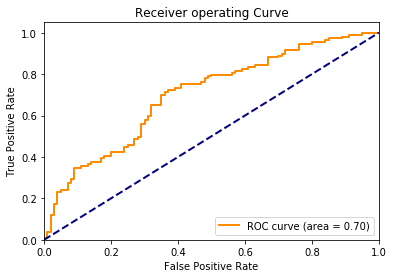

In [714]:
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating Curve')
plt.legend(loc="lower right")
plt.show()

In [720]:
pred_probsTrain = clf.predict_proba(xTrain) # probabilities that change today is higher or lower than yesterday
pred_probsVal = clf.predict_proba(xVal)

In [722]:
metaCLF = svm.SVC(kernel='rbf', probability= True) # change kernels between linear, poly and rbf as fit.
metaCLF.fit(pred_probsTrain, yTrainMod) # Train the probabilities against the actual change
metaProbsTest = metaCLF.predict_proba(pred_probsVal)
metaTest = metaCLF.predict(pred_probsVal)

In [724]:
conf = confusion_matrix(yValMod,metaTest)
tn, fp, fn, tp = conf.ravel()
print("TRUE NEGATIVE: %d" % tn)
print("TRUE POSITIVE: %d" % tp)
print("FALSE POSITIVE: %d" % fp)
print("FALSE NEGATIVE: %d" % fn)
print("Weight of Buy in data set: %f" % (sum(yVal==1)/len(yVal)))

TRUE NEGATIVE: 81
TRUE POSITIVE: 35
FALSE POSITIVE: 38
FALSE NEGATIVE: 55
Weight of Buy in data set: 0.478469


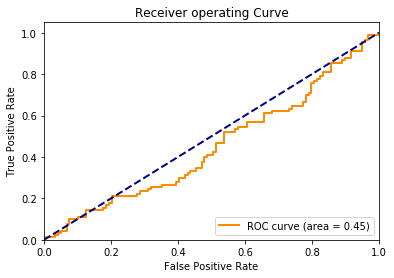

In [726]:
# Compute ROC curve and ROC area for each class

y_score = metaCLF.predict_proba(pred_probsVal)
y_score = y_score[:,1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(1):
    fpr[i], tpr[i], _ = roc_curve(yValMod, y_score,pos_label=2)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating Curve')
plt.legend(loc="lower right")
plt.show()